<div style="text-align:center;vertical-align:middle;background-color:#34495E;display:inline-block;border:5px;border-style:round;border-color:#0000ff;border-radius:25px;width:1030px;height:60px">
    <h1 style="text-align:center;color:lightgray;font-size:200%;">Titanic - Machine Learning from Disaster</h1>
</div>

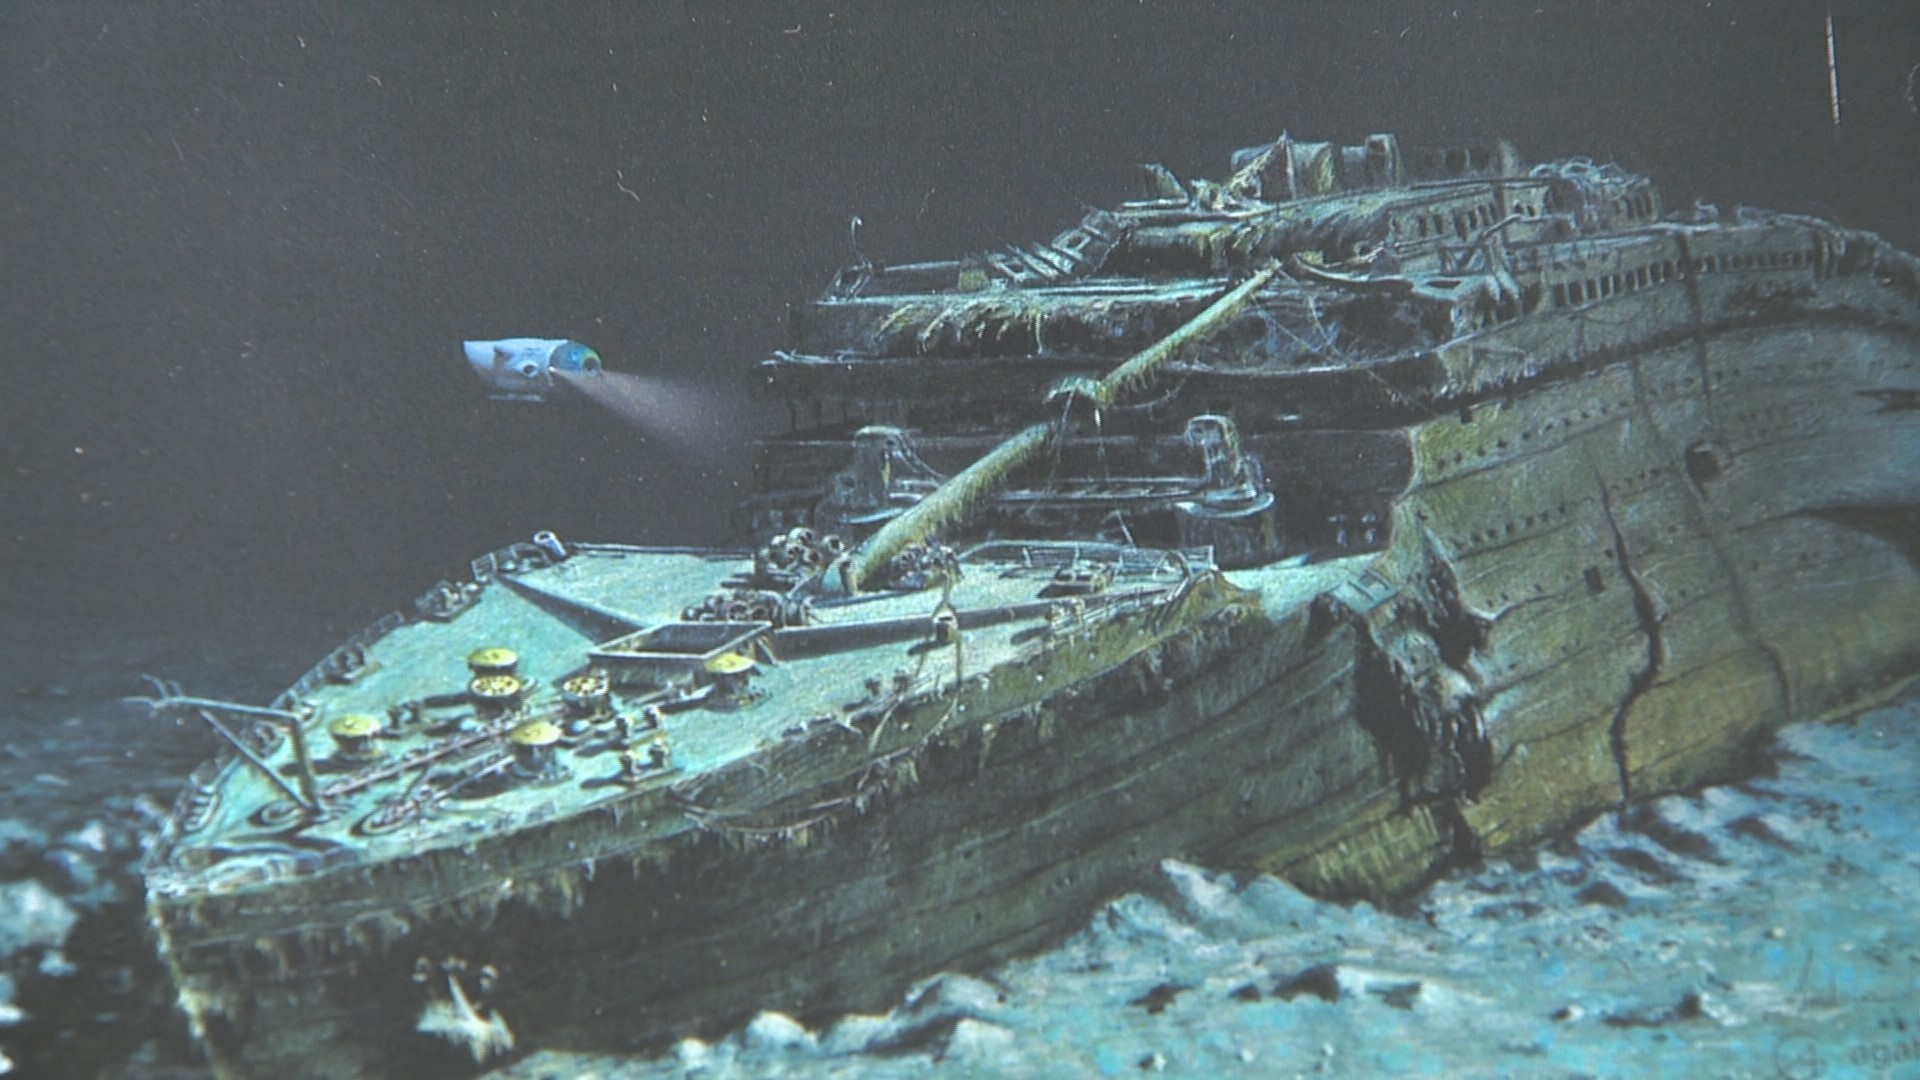

The RMS Titanic, a luxury steamship, sank in the early hours of April 15, 1912, off the coast of Newfoundland in the North Atlantic after sideswiping an iceberg during its maiden voyage. Of the 2,240 passengers and crew on board, more than 1,500 lost their lives in the disaster.

<table align="left">
<tr style="background-color:seagreen;color:white;">
<td></td>
<td>Prediction of Survival on The Titanic</td>
<td></td>
</tr>
</table>

### CONTENT
<a id='content'></a>


- 1) [Exploratory Data Analysis](#phase1)
    * 1.1 [Data Review](#eda1)
    * 1.2 [Correlations](#eda2)
    * 1.3 [Outliers](#eda3)
    * 1.4 [Review of Features and Filling Missing Values](#eda4)


- 2) [Data pre-processing](#phase2)
    * 2.1 [Transformers for Encoders](#pre1)
    * 2.2 [Train-Test Split](#pre2)
    
    
- 3) [Model Building](#phase3)
    * 3.1 [GradientBoostingClassifier](#model1)
    * 3.2 [KNeighborsClassifier](#model2)
    * 3.3 [RandomForestClassifier](#model3)
    * 3.4 [XGBoostClassifier](#model4)
    
    
- 4) [Comparison of Models](#phase4)

      
- 5) [Prediction](#conc)

<div class="alert alert-block alert-success">
    
<b>1. Exploratory Data Analysis<a id='phase1'></a></b>
    
</div>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
import math
import warnings
warnings.filterwarnings('ignore')

# Libraries for Style
from colorama import Fore, Style
from yellowbrick.style import set_palette
set_palette('flatui')

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.float_format', '{:.3f}'.format)

## 1.1 Data Review
<a id='eda1'>

***train data***

In [ ]:
train_data = pd.read_csv('../input/titanic/train.csv')
train_data.head()

In [ ]:
train_data.info()

In [ ]:
train_data.shape, train_data.size

In [ ]:
train_data.isnull().sum()[train_data.isnull().sum()>0]

In [ ]:
train_data.duplicated().sum()

In [ ]:
train_data.nunique()

In [ ]:
train_data[train_data.Survived==0].iloc[:,2:].describe().style.background_gradient(cmap='twilight_r')

In [ ]:
train_data[train_data.Survived==1].iloc[:,2:].describe().style.background_gradient(cmap='twilight_r')

***test data***

In [ ]:
test_data = pd.read_csv('../input/titanic/test.csv')
test_data.head()

In [ ]:
test_data.info()

In [ ]:
test_data.shape, test_data.size

In [ ]:
test_data.isnull().sum()[test_data.isnull().sum()>0]
# there are missing values on the test data

***temporary dataframe for analysis***

In [ ]:
df_temp = train_data.append(test_data, ignore_index=True)
df_temp['FamilySize'] = df_temp['SibSp'] + df_temp['Parch']
df_temp.head()

## 1.2 Correlations
<a id='eda2'>

In [ ]:
sns.pairplot(train_data.iloc[:, 2:])

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(train_data.corr(), annot=True, cmap='viridis', linewidth=1, linecolor='black', fmt='.3f')

In [ ]:
train_data.corr()['Survived'].drop('Survived').sort_values().plot.barh()

## 1.3 Outliers
<a id='eda3'>

In [ ]:
# OUTLIERS

iqr_factor = [1.5, 2]
list1, list2 = [], []

for factor in iqr_factor:
    count = 0
    print(f'Outliers for {factor} IQR :')
    print('-------------------------------------')
    for col in train_data.select_dtypes(['int64', 'float64']):
    
        IQR = train_data[col].quantile(0.75) - train_data[col].quantile(0.25)
        lower_lim = train_data[col].quantile(0.25) - factor*IQR
        upper_lim = train_data[col].quantile(0.75) + factor*IQR
    
        cond = train_data[(train_data[col] < lower_lim) | (train_data[col] > upper_lim)].shape[0]
        
        if cond > 0 and factor == 1.5:
            list1.append(train_data[(train_data[col] < lower_lim) | (train_data[col] > upper_lim)].index.tolist())
        elif cond > 0 and factor == 2:
            list2.append(train_data[(train_data[col] < lower_lim) | (train_data[col] > upper_lim)].index.tolist())
        
        if cond > 0: print(f'{col:<30} : ', cond); count += cond
    print(f'\n{Fore.BLUE}TOTAL OUTLIERS FOR {factor} IQR : {count}{Style.RESET_ALL}')
    print('')

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(14,8))
sns.boxplot(data=train_data, x='Survived', y='Age', ax=ax[0,0])
sns.boxplot(data=train_data, x='Survived', y='Fare', ax=ax[0,1])
sns.boxplot(data=train_data, x='Survived', y='SibSp', ax=ax[1,0])
sns.boxplot(data=train_data, x='Survived', y='Parch', ax=ax[1,1])

plt.tight_layout();

## 1.4 Review of Features and Filling Missing Values
<a id='eda4'>

[CONTENT](#content)

In [ ]:
train_data.columns

***Pclass***

In [ ]:
plt.figure(figsize=(13,5))

x = train_data['Pclass'].value_counts().index
y = train_data['Pclass'].value_counts().values

plt.subplot(121)
g = plt.bar(x,y,label='Pclass', color=['seagreen','#34495E', 'brown'])
plt.bar_label(g, padding=3, size=13), plt.ylim(0, 600)

plt.xlabel('Pclass'), plt.ylabel('Number of Passengers') 
plt.title('Distribution of Pclass', size=13)
   
plt.subplot(122)
plt.pie(y, labels=x, autopct='%0.1f%%', radius=1.2, textprops={'color':'black','fontsize': 13}, 
        colors=['seagreen','#34495E', 'brown'])

plt.tight_layout();

In [ ]:
g = sns.countplot(data=train_data, x='Pclass', hue='Survived')
g.bar_label(g.containers[0]), g.bar_label(g.containers[1]);

***sex***

In [ ]:
plt.figure(figsize=(13,5))

x = train_data['Sex'].value_counts().index
y = train_data['Sex'].value_counts().values

plt.subplot(121)
g = plt.bar(x,y,label='Sex', color=['seagreen','#34495E'])
plt.bar_label(g, padding=3, size=13), plt.ylim(0, 700)

plt.xlabel('Gender'), plt.ylabel('Number of Passengers') 
plt.title('Distribution of Gender', size=13)
    
plt.subplot(122)
plt.pie(y, labels=x, autopct='%0.1f%%', radius=1.2, textprops={'color':'black','fontsize': 13}, 
        colors=['seagreen','#34495E'])

plt.tight_layout();

In [ ]:
g = sns.countplot(data=train_data, x='Sex', hue='Survived')
g.bar_label(g.containers[0]), g.bar_label(g.containers[1]);

***SibSp - Parch*** 

SibSp: Number of siblings and spouses of the passenger aboard

Parch: Number of parents and children of the passenger aboard

In [ ]:
g = sns.countplot(data=train_data, x='SibSp', hue='Survived')
g.bar_label(g.containers[0]), g.bar_label(g.containers[1])
g.set_ylim(0,450), plt.legend(loc='upper right');

In [ ]:
g = sns.countplot(data=train_data, x='Parch', hue='Survived')
g.bar_label(g.containers[0]), g.bar_label(g.containers[1])
g.set_ylim(0,500), plt.legend(loc='upper right');

***Age***

In [ ]:
plt.figure(figsize=(14,7))
sns.histplot(data=train_data, x='Age', hue='Survived', bins=50)

In [ ]:
train_data.Age.isnull().sum(), test_data.Age.isnull().sum()

In [ ]:
train_data[train_data.Age.isnull()][['SibSp', 'Parch']].describe().T

In [ ]:
# combined dataframe
df_temp[df_temp.Age.isna()].groupby(['SibSp', 'Parch']).Age.value_counts(dropna=False)

In [ ]:
df_temp.groupby(['SibSp','Parch','Pclass']).Age.mean()

In [ ]:
df_temp.Age.fillna(df_temp.groupby(['SibSp','Parch','Pclass']).Age.transform('mean'), inplace=True)
df_temp.Age.fillna(df_temp[(df_temp.SibSp==1) & (df_temp.Parch>=6)].Age.mean(), inplace=True)

In [ ]:
df_temp.Age = df_temp.Age.apply(math.ceil)

In [ ]:
train_data.Age = df_temp.iloc[:891]['Age'].values
test_data.Age = df_temp.iloc[891:]['Age'].values

In [ ]:
train_data.Age.isnull().sum(), test_data.Age.isnull().sum()

In [ ]:
test_data.Age.unique()

***Embarked*** 
    
Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

In [ ]:
plt.figure(figsize=(13,5))

x = train_data['Embarked'].value_counts().index
y = train_data['Embarked'].value_counts().values

plt.subplot(121)
g = plt.bar(x,y,label='Embarked',color=['seagreen','#34495E', 'brown'])
plt.bar_label(g, padding=3, size=13), plt.ylim(0, 700)

plt.xlabel('Embarked'), plt.ylabel('Number of Passengers') 
plt.title('Port of Embarkation', size=13)
    
plt.subplot(122)
plt.pie(y, labels=x, autopct='%0.1f%%', radius=1.2, textprops={'color':'black','fontsize': 13}, 
        colors=['seagreen','#34495E', 'brown'])

plt.tight_layout();

In [ ]:
g = sns.countplot(data=train_data, x='Embarked', hue='Survived')
g.bar_label(g.containers[0]), g.bar_label(g.containers[1]);

In [ ]:
train_data[train_data.Embarked.isna()]

In [ ]:
train_data.groupby(['Embarked', train_data.Pclass.astype(str)]).Fare.describe().style.background_gradient()

In [ ]:
train_data.Embarked.fillna('S', inplace=True)

***Fare***

In [ ]:
plt.figure(figsize=(14,7))
sns.histplot(data=train_data, x='Fare', hue='Survived', bins=50)

In [ ]:
train_data.groupby('Survived').Fare.describe()

In [ ]:
test_data[test_data.Fare.isna()]

In [ ]:
df_temp[df_temp.Ticket=='3701']

In [ ]:
fare_value = df_temp[(df_temp.Pclass==3) & (df_temp.Embarked=='S') & (df_temp.FamilySize==0)].Fare
fare_value.describe()
# fare values have outliers so median might be a viable option

In [ ]:
test_data.Fare.fillna(fare_value.median(), inplace=True)

***Ticket***

In [ ]:
df_temp.Ticket.value_counts()

In [ ]:
nonunique_tickets = df_temp.Ticket.value_counts()[df_temp.Ticket.value_counts().values>1]
nonunique_tickets.index

In [ ]:
unique_tickets = df_temp.Ticket.value_counts()[df_temp.Ticket.value_counts().values==1]
unique_tickets.index

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(14,8))

sns.countplot(data=df_temp[(df_temp.FamilySize>0) & (df_temp.Ticket.isin(unique_tickets.index))], x='Sex', 
              hue='Survived', ax=ax[0,0]) 
ax[0,0].bar_label(ax[0,0].containers[0], size=13), ax[0,0].bar_label(ax[0,0].containers[1], size=13)

sns.countplot(data=df_temp[(df_temp.FamilySize==0) & (df_temp.Ticket.isin(unique_tickets.index))], x='Sex', 
        hue='Survived', ax=ax[0,1]) 
ax[0,1].bar_label(ax[0,1].containers[0],size=13), ax[0,1].bar_label(ax[0,1].containers[1],size=13)

sns.countplot(data=df_temp[(df_temp.FamilySize>0) & (df_temp.Ticket.isin(nonunique_tickets.index))], x='Sex', 
              hue='Survived', ax=ax[1,0])
ax[1,0].bar_label(ax[1,0].containers[0], size=13), ax[1,0].bar_label(ax[1,0].containers[1], size=13)

sns.countplot(data=df_temp[(df_temp.FamilySize==0) & (df_temp.Ticket.isin(nonunique_tickets.index))], x='Sex', 
              hue='Survived', ax=ax[1,1])
ax[1,1].bar_label(ax[1,1].containers[0], size=13), ax[1,1].bar_label(ax[1,1].containers[1], size=13)

ax[0,0].set_ylim(0, 22.5), ax[0,1].set_ylim(0, 350), ax[1,0].set_ylim(0, 140), ax[1,1].set_ylim(0, 60)

ax[0,0].set_title('Own Ticket with SibSp/Parch', size=13), 
ax[0,1].set_title('Own Ticket without SibSp/Parch', size=13)
ax[1,0].set_title('Collective Ticket with SibSp/Parch', size=13), 
ax[1,1].set_title('Collective Ticket without SibSp/Parch', size=13)

plt.tight_layout();

In [ ]:
train_data.Ticket = train_data.Ticket.apply(lambda x: 'own' if x in unique_tickets else 'collective')
test_data.Ticket = test_data.Ticket.apply(lambda x: 'own' if x in unique_tickets else 'collective')

In [ ]:
train_data.head()

In [ ]:
test_data.head()

***survived***

In [ ]:
plt.figure(figsize=(13,5))

x = train_data['Survived'].value_counts().index
y = train_data['Survived'].value_counts().values

plt.subplot(121)
g = plt.bar(x,y,label='Survived',color=['seagreen','#34495E'])
plt.bar_label(g, padding=3, size=13), plt.ylim(0, 700)

plt.xlabel('Survived'), plt.ylabel('Number of Passengers') 
plt.title('Distribution of Survived', size=13)
    
plt.subplot(122)
plt.pie(y, labels=x, autopct='%0.1f%%', radius=1.2, textprops={'color':'black','fontsize': 13}, 
        colors=['seagreen','#34495E'])

plt.tight_layout();

***

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(pd.get_dummies(train_data.drop(['PassengerId','Name','Cabin'], 1)).corr(), annot=True)

In [ ]:
pd.get_dummies(train_data.drop(['PassengerId','Name','Cabin'], 1)).corr()['Survived'] \
                                            .drop('Survived').sort_values().plot.barh()

***

<div class="alert alert-block alert-success">
    
<b>2. Data Pre-Processing<a id='phase2'></a></b>
    
</div>

[CONTENT](#content)

In [ ]:
train_data.drop(['PassengerId','Name','Cabin'], 1, inplace=True)
test_data.drop(['PassengerId','Name','Cabin'], 1, inplace=True)

In [ ]:
print(train_data.isnull().sum().sum())
train_data.head(3)

In [ ]:
print(test_data.isnull().sum().sum())
test_data.head(3)

## 2.1 Transformers for Encoders
<a id='pre1'>

In [ ]:
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

In [ ]:
{column: list(train_data[column].unique()) for column in train_data.select_dtypes('O').columns}

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('enc', OneHotEncoder(drop='if_binary'), ['Sex','Embarked','Ticket'])
], remainder='passthrough')

In some cases, OrdinalEncoder can be used instead of OneHotEncoder even for nominal (unordered) features when using tree-based ML algorithms.

## 2.2 Train-Test Split
<a id='pre2'>

In [ ]:
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=15)

In [ ]:
print("Train features shape : ", X_train.shape)
print("Test features shape  : ", X_test.shape)

In [ ]:
y_train.value_counts(), y_test.value_counts()

<div class="alert alert-block alert-success">
    
<b>3. Model Building<a id='phase3'></a></b>
    
</div>

[CONTENT](#content)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import cross_val_score,cross_validate,GridSearchCV

from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score
from sklearn.metrics import average_precision_score,precision_recall_curve,plot_precision_recall_curve

In [ ]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

## 3.1 GradientBoostingClassifier
<a id='model1'>

[CONTENT](#content)

In [ ]:
gbc_model = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('clf', GradientBoostingClassifier(random_state=42))
])

gbc_model.fit(X_train, y_train)

In [ ]:
eval_metric(gbc_model, X_train, y_train, X_test, y_test)

In [ ]:
cross_val_score(gbc_model, X_train, y_train, cv=10, scoring='accuracy').mean()

In [ ]:
cross_val_score(gbc_model, X_train, y_train, cv=10, scoring='recall').mean()

In [ ]:
# GRID SEARCH

model = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('clf', GradientBoostingClassifier(random_state=42))
])

param_grid = {'clf__n_estimators': [64, 100, 128, 175], 'clf__max_depth': [3, 4], 'clf__subsample': [0.5, 1], 
              'clf__max_features' : [None, 3, 5, 7], 'clf__learning_rate': [0.05, 0.08, 0.1, 0.3]} 

%time gbc_grid_model = GridSearchCV(model, param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1).fit(X_train, y_train)

print('\n', gbc_grid_model.best_params_)
print('\n', gbc_grid_model.best_estimator_)
print('\n', 'Best Score :', gbc_grid_model.best_score_)

In [ ]:
eval_metric(gbc_grid_model, X_train, y_train, X_test, y_test)

In [ ]:
# model tuning
gbc_tuned_model = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('clf', GradientBoostingClassifier(learning_rate=0.01, n_estimators=250, random_state=42, subsample=0.5))
]).fit(X_train, y_train)

In [ ]:
eval_metric(gbc_tuned_model, X_train, y_train, X_test, y_test)

In [ ]:
cross_val_score(gbc_tuned_model, X_train, y_train, cv=10, scoring='accuracy').mean()

In [ ]:
cross_val_score(gbc_tuned_model, X_train, y_train, cv=10, scoring='recall').mean()

In [ ]:
y_train_pred = gbc_model.predict(X_train)
y_pred = gbc_model.predict(X_test)

gbc_test_accuracy = accuracy_score(y_test, y_pred)
gbc_train_accuracy = accuracy_score(y_train, y_train_pred)
gbc_crosvalscore_accuracy = cross_val_score(gbc_model, X_train, y_train, cv=10, scoring='accuracy').mean()

gbc_test_recall = recall_score(y_test, y_pred)
gbc_train_recall = recall_score(y_train, y_train_pred)
gbc_crosvalscore_recall = cross_val_score(gbc_model, X_train, y_train, cv=10, scoring='recall').mean()

## 3.2 KNeighborsClassifier
<a id='model2'>

[CONTENT](#content)

In [ ]:
knn_model = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('scaler', MinMaxScaler()),
      ('clf', KNeighborsClassifier())
])

knn_model.fit(X_train, y_train)

In [ ]:
eval_metric(knn_model, X_train, y_train, X_test, y_test)

In [ ]:
cross_val_score(knn_model, X_train, y_train, cv=10, scoring='accuracy').mean()

In [ ]:
cross_val_score(knn_model, X_train, y_train, cv=10, scoring='recall').mean()

In [ ]:
# GRID SEARCH

model = Pipeline(steps=[('preprocessor', preprocessor),('scaler', MinMaxScaler()),('clf', KNeighborsClassifier())])

param_grid = {'clf__n_neighbors': range(1,31), 'clf__p': [1,2], 'clf__weights': ['uniform', 'distance'],
              'clf__leaf_size': [10, 15, 25, 30]}

knn_grid_model = GridSearchCV(model, param_grid, cv=10, verbose=1, scoring='accuracy', n_jobs=-1)

%time knn_grid_model.fit(X_train,y_train)

print('\n', knn_grid_model.best_params_)
print('\n', knn_grid_model.best_estimator_)
print('\n', 'Best Score :', knn_grid_model.best_score_)

In [ ]:
eval_metric(knn_grid_model, X_train, y_train, X_test, y_test)

In [ ]:
knn_grid_model = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('scaler', MinMaxScaler()),
      ('clf', KNeighborsClassifier(leaf_size=10, n_neighbors=13, p=1))
]).fit(X_train, y_train)

In [ ]:
y_train_pred = knn_grid_model.predict(X_train)
y_pred = knn_grid_model.predict(X_test)

knn_test_accuracy = accuracy_score(y_test, y_pred)
knn_train_accuracy = accuracy_score(y_train, y_train_pred)
knn_crosvalscore_accuracy = cross_val_score(knn_grid_model, X_train, y_train, cv=10, scoring='accuracy').mean()

knn_test_recall = recall_score(y_test, y_pred)
knn_train_recall = recall_score(y_train, y_train_pred)
knn_crosvalscore_recall = cross_val_score(knn_grid_model, X_train, y_train, cv=10, scoring='recall').mean()

## 3.3 RandomForestClassifier
<a id='model3'>

[CONTENT](#content)

In [ ]:
rf_model = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))
])

rf_model.fit(X_train, y_train)

In [ ]:
eval_metric(rf_model, X_train, y_train, X_test, y_test)

In [ ]:
cross_val_score(rf_model, X_train, y_train, cv=10, scoring='accuracy').mean()

In [ ]:
cross_val_score(rf_model, X_train, y_train, cv=10, scoring='recall').mean()

In [ ]:
# GRID SEARCH

model = Pipeline(steps=[('preprocessor', preprocessor), ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])

param_grid = {'clf__n_estimators':[64, 100, 128, 175],
              'clf__max_features':[3, 6, 'auto'],
              'clf__max_depth':[5, 7, 9],
              'clf__min_samples_split':[2, 6, 10],
              'clf__class_weight': [{1: w} for w in [1, 1.2, 1.3]]}

rf_grid_model = GridSearchCV(model, param_grid, cv=10, verbose=1, scoring='accuracy', n_jobs=-1)

%time rf_grid_model.fit(X_train,y_train)

print('\n', rf_grid_model.best_params_)
print('\n', rf_grid_model.best_estimator_)
print('\n', 'Best Score :', rf_grid_model.best_score_)

In [ ]:
eval_metric(rf_grid_model, X_train, y_train, X_test, y_test)

In [ ]:
# model tuning
rf_tuned_model = Pipeline(steps=[('preprocessor', preprocessor),
                ('clf', RandomForestClassifier(class_weight={1: 1}, max_depth=7, n_estimators=128, n_jobs=-1,
                                               max_features=6, min_samples_split=6, random_state=42))]).fit(X_train, y_train)

In [ ]:
eval_metric(rf_tuned_model, X_train, y_train, X_test, y_test)

In [ ]:
cross_val_score(rf_tuned_model, X_train, y_train, cv=10, scoring='accuracy').mean()

In [ ]:
cross_val_score(rf_tuned_model, X_train, y_train, cv=10, scoring='recall').mean()

In [ ]:
y_train_pred = rf_tuned_model.predict(X_train)
y_pred = rf_tuned_model.predict(X_test)

rf_test_accuracy = accuracy_score(y_test, y_pred)
rf_train_accuracy = accuracy_score(y_train, y_train_pred)
rf_crosvalscore_accuracy = cross_val_score(rf_tuned_model, X_train, y_train, cv=10, scoring='accuracy').mean()

rf_test_recall = recall_score(y_test, y_pred)
rf_train_recall = recall_score(y_train, y_train_pred)
rf_crosvalscore_recall = cross_val_score(rf_tuned_model, X_train, y_train, cv=10, scoring='recall').mean()

## 3.4 XGBoost Classifier
<a id='model4'>

[CONTENT](#content)

In [ ]:
xgb_model = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('clf', XGBClassifier(eval_metric='logloss', random_state=42))
])

xgb_model.fit(X_train, y_train)

In [ ]:
eval_metric(xgb_model, X_train, y_train, X_test, y_test)

In [ ]:
cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='accuracy').mean()

In [ ]:
cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='recall').mean()

In [ ]:
# model tuning
xgb_tuned_model = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('clf', XGBClassifier(eval_metric='logloss', colsample_bytree= 0.5, max_depth=6, learning_rate=0.03, 
                            subsample=0.8, n_estimators=128, random_state=42))
]).fit(X_train,y_train)

In [ ]:
eval_metric(xgb_tuned_model, X_train, y_train, X_test, y_test)

In [ ]:
cross_val_score(xgb_tuned_model, X_train, y_train, cv=10, scoring='accuracy').mean()

In [ ]:
cross_val_score(xgb_tuned_model, X_train, y_train, cv=10, scoring='recall').mean()

In [ ]:
y_train_pred = xgb_tuned_model.predict(X_train)
y_pred = xgb_tuned_model.predict(X_test)

xgb_test_accuracy = accuracy_score(y_test, y_pred)
xgb_train_accuracy = accuracy_score(y_train, y_train_pred)
xgb_crosvalscore_accuracy = cross_val_score(xgb_tuned_model, X_train, y_train, cv=10, scoring='accuracy').mean()

xgb_test_recall = recall_score(y_test, y_pred)
xgb_train_recall = recall_score(y_train, y_train_pred)
xgb_crosvalscore_recall = cross_val_score(xgb_tuned_model, X_train, y_train, cv=10, scoring='recall').mean()

***

<div class="alert alert-block alert-success">
    
<b>4. COMPARISON OF MODELS<a id='phase4'></b>
    
</div>

[CONTENT](#content)

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(26,6))
plt.rcParams.update({'font.size': 22})

classifiers = [gbc_model, knn_grid_model, rf_tuned_model, xgb_tuned_model]
for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, X_test, y_test, cmap=plt.cm.Purples, ax=ax)
    ax.grid(False)
    ax.set_title(type(cls.named_steps['clf']).__name__, size=22, pad=10)

plt.tight_layout()
plt.show()

In [ ]:
compare = pd.DataFrame({
   'Model': ['Gradient Boosting', 'KNN',  'Random Forest', 'XGBoost'],
   'test_accuracy': [gbc_test_accuracy, knn_test_accuracy, rf_test_accuracy, xgb_test_accuracy],
   'train_accuracy': [gbc_train_accuracy, knn_train_accuracy, rf_train_accuracy, xgb_train_accuracy],
   'crossval_accuracy':[gbc_crosvalscore_accuracy,knn_crosvalscore_accuracy,rf_crosvalscore_accuracy,xgb_crosvalscore_accuracy],
   'test_recall': [gbc_test_recall, knn_test_recall, rf_test_recall, xgb_test_recall],
   'train_recall': [gbc_train_recall, knn_train_recall, rf_train_recall, xgb_train_recall],
   'crossval_recall':[gbc_crosvalscore_recall,knn_crosvalscore_recall,rf_crosvalscore_recall,xgb_crosvalscore_recall],
})

compare

In [ ]:
plt.figure(figsize=(14,14))

index = 0
colors={'Gradient Boosting': 'seagreen', 'Random Forest': 'orange', 'KNN': 'brown', 'XGBoost': '#34495E'}

for col in compare.iloc[:, 1:].columns:    
    index += 1
    plt.subplot(3,2,index)
    a = sns.barplot(data=compare.sort_values(col, ascending=False), x='Model', y=col, palette=colors)
    a.bar_label(a.containers[0], fmt='%.3f', fontsize=13), plt.ylim(0, 1)
    plt.title(f'Distribution of {col} Scores', fontsize=14, pad=10)
plt.tight_layout()

In [ ]:
# FINAL MODEL

preprocessor = ColumnTransformer(transformers=[
    ('enc', OneHotEncoder(drop='if_binary'), ['Sex','Embarked','Ticket'])
], remainder='passthrough')

gbc_model = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('clf', GradientBoostingClassifier(random_state=42))
]).fit(X,y)

<div class="alert alert-block alert-success">
    
<b>5. PREDICTION OF TEST DATA<a id='conc'></b>
    
</div>

[CONTENT](#content)

In [ ]:
test_data.head()

In [ ]:
test_ids = pd.read_csv('../input/titanic/test.csv')['PassengerId']
test_ids.head()

In [ ]:
test_predictions = gbc_model.predict(test_data)
submission = pd.DataFrame({'PassengerId': test_ids.values, 'Survived': test_predictions})
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)